# Notebook Imports

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# TensorFlow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

2024-10-22 11:56:35.993084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 11:56:35.993227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 11:56:36.127154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

## Constants

In [3]:
FILE = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

# Step 1: Data Collection and Loading

* Large Movie Review Dataset [Link](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)

In [4]:
data = pd.read_csv(FILE)
df_full = pd.DataFrame(data)

df_full.drop([0], axis=0, inplace=True)
df_full.reset_index(drop=True, inplace=True)

df = df_full.sample(frac=0.1)
df.head()

,review,sentiment
10149,This movie appears to have been made by someon...,negative
6912,"Shamefully, before I saw this film, I was unfa...",positive
11229,"Terry Gilliam's fantastic, twisted story of a ...",positive
9180,"This was a great movie with a good cast, all o...",positive
25569,Story of a good-for-nothing poet and a sidekic...,negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 10149 to 9826
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [6]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
review       0
sentiment    0
dtype: int64


In [7]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")


The shape of the data: (5000, 2)

The types of the data: 
review       object
sentiment    object
dtype: object



# Step 2: Data Preprocessing

* **Text Cleaning:** Remove any HTML tags, special characters, numbers, and other non-alphabetic characters.
* **Tokenization:** Split the reviews into individual words (tokens).
* **Stop Words Removal:** Remove common words that do not contribute to the sentiment, such as 'and', 'the', 'is', etc.
* **Lemmatization:** Reduce words to their base or root form.

### Text Cleaning

In [8]:
df.nunique()

review       4997
sentiment       2
dtype: int64

In [9]:
df = df.drop_duplicates()
print(df.shape)
df.head()

(4997, 2)


,review,sentiment
10149,This movie appears to have been made by someon...,negative
6912,"Shamefully, before I saw this film, I was unfa...",positive
11229,"Terry Gilliam's fantastic, twisted story of a ...",positive
9180,"This was a great movie with a good cast, all o...",positive
25569,Story of a good-for-nothing poet and a sidekic...,negative


In [10]:
# remove html tags from text
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

### Tokenization, Stop Words Removal, Lemmatization

In [11]:
def clean_review(text, wl=WordNetLemmatizer(), 
               stop_words=set(stopwords.words('english'))):
    # Remove HTML tags
    cleaned_text = remove_html_tags(text)
    
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(wl.lemmatize(word))
    
    filtered_words = ' '.join(filtered_words)    
     
    return filtered_words

In [12]:
%%time
nested_list = df.review.apply(clean_review)
df['review'] = nested_list

CPU times: user 14.1 s, sys: 112 ms, total: 14.2 s
Wall time: 14.2 s


In [13]:
df.head()

,review,sentiment
10149,movie appears made someone good idea also neve...,negative
6912,shamefully saw film unfamiliar helena bonham r...,positive
11229,terry gilliam fantastic twisted story virus de...,positive
9180,great movie good cast hitting cylinder dianne ...,positive
25569,story poet sidekick singer put word music dire...,negative


In [14]:
nested_list.head()

10149    movie appears made someone good idea also neve...
6912     shamefully saw film unfamiliar helena bonham r...
11229    terry gilliam fantastic twisted story virus de...
9180     great movie good cast hitting cylinder dianne ...
25569    story poet sidekick singer put word music dire...
Name: review, dtype: object

In [15]:
# Convert labels to binary (0 and 1)
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

### Positive and Negative Words

In [16]:
# Identify the index of positive review
ids_positive = df[df.sentiment == 1].index
ids_positive

Index([ 6912, 11229,  9180,  8791, 45554,  6207, 41405, 48229, 17622, 27748,
       ...
       32692, 47154, 28267, 47969,  9351, 16251, 35205,  9349, 16882,   843],
      dtype='int64', length=2528)

In [17]:
# Identify the index of negative review
ids_negative = df[df.sentiment == 0].index
ids_negative

Index([10149, 25569, 39878, 45191, 31377, 43914, 28161, 13948, 14821, 41668,
       ...
       19319,  1768, 36645,  7531, 47825, 18711,  5666, 27120, 45622,  9826],
      dtype='int64', length=2469)

In [18]:
nested_list_positive = nested_list.loc[ids_positive]
nested_list_negative = nested_list.loc[ids_negative]

nested_list_positive.shape, nested_list_negative.shape

((2528,), (2469,))

In [19]:
list_positive = [item for sublist in nested_list_positive for item in sublist.split(" ")]
positive_words = pd.Series(list_positive).value_counts()

list_negative = [item for sublist in nested_list_negative for item in sublist.split(" ")]
negative_words = pd.Series(list_negative).value_counts()

positive_words.shape[0], negative_words.shape[0]

(24695, 23433)

In [20]:
positive_words[:10]

film         4786
movie        4512
one          2756
like         1837
time         1570
good         1425
story        1406
character    1345
great        1334
see          1319
Name: count, dtype: int64

In [21]:
negative_words[:10]

movie        5694
film         4203
one          2478
like         2251
would        1515
even         1513
bad          1421
good         1420
time         1411
character    1394
Name: count, dtype: int64

# Step 3: Exploratory Data Analysis (EDA)

* Visualize the distribution of reviews by sentiment (positive vs. negative)
* Analyze the most common words in positive and negative reviews

In [22]:
amount_of_positive_review = df.sentiment.value_counts()[1]
amount_of_negative_review = df.sentiment.value_counts()[0]

amount_of_positive_review, amount_of_negative_review

(2528, 2469)

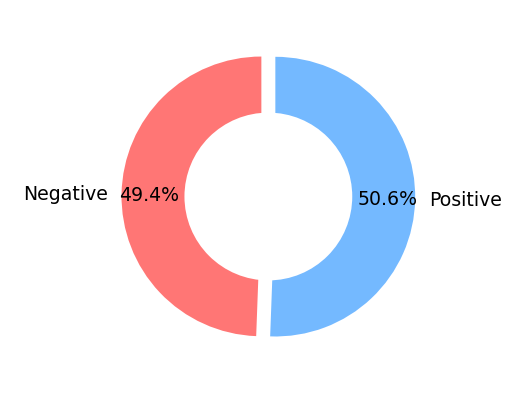

In [23]:
categoty_names = ['Negative', 'Positive']
sizes = [amount_of_negative_review, amount_of_positive_review]
custom_colours = ['#ff7675', '#74b9ff']
offset = [0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

#draw a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

### Word Cloud of Positive and Negative Reviews

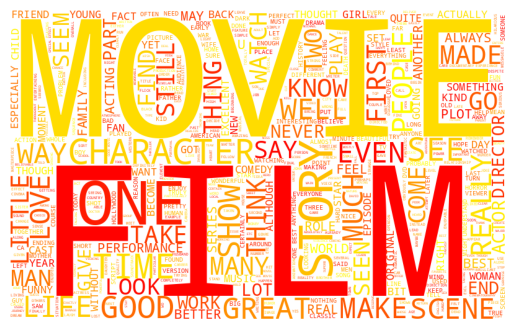

In [24]:
# Generate the text as a string for the Word Cloud
positive_str = ' '.join(list_positive)

wc = WordCloud(background_color='white', max_words=1000, colormap='autumn', width=800, height=500)
wc.generate(positive_str.upper())
plt.axis("off")
plt.imshow(wc)

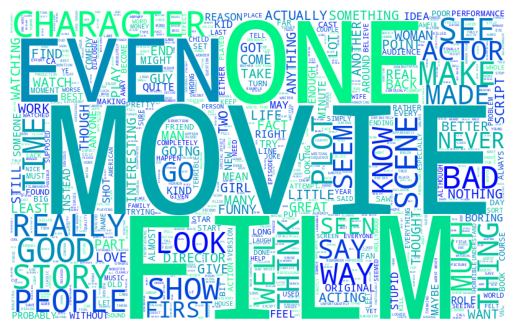

In [25]:
# Generate the text as a string for the Word Cloud
negative_str = ' '.join(list_negative)

wc = WordCloud(background_color='white', max_words=1000, colormap='winter', width=800, height=500)
wc.generate(negative_str.upper())
plt.axis("off")
plt.imshow(wc)

# Step 4: Model Preparation

In [26]:
max_length = max(len(sublist) for sublist in nested_list)
print(max_length)

4396


In [27]:
df.reset_index()
df.head()

,review,sentiment
10149,movie appears made someone good idea also neve...,0
6912,shamefully saw film unfamiliar helena bonham r...,1
11229,terry gilliam fantastic twisted story virus de...,1
9180,great movie good cast hitting cylinder dianne ...,1
25569,story poet sidekick singer put word music dire...,0


In [28]:
data_dict = {
    "Preprocessed Review": df['review'],
    "Target": df['sentiment']
}

df_prep = pd.DataFrame(data_dict)
df_prep.head()

,Preprocessed Review,Target
10149,movie appears made someone good idea also neve...,0
6912,shamefully saw film unfamiliar helena bonham r...,1
11229,terry gilliam fantastic twisted story virus de...,1
9180,great movie good cast hitting cylinder dianne ...,1
25569,story poet sidekick singer put word music dire...,0


In [29]:
count_vect = CountVectorizer(ngram_range=(1, 2))        
transformer = TfidfTransformer(norm='l2', sublinear_tf=True)
counts = count_vect.fit_transform(df_prep['Preprocessed Review'])

X = transformer.fit_transform(counts)
y = np.array(df_prep['Target'].values, dtype='float64')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3997, 441830), (1000, 441830), (3997,), (1000,))

In [31]:
LABELS = ['Negative', 'Positive']

In [32]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots a confusion matrix using the true and predicted labels.

    Args:
        y_true (array-like): The true labels.
        y_pred (array-like): The predicted labels.
        labels (array-like): The list of labels to index the matrix.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Step 5: Basic Model Implementation

## Logistic Regression

In [33]:
logreg = LogisticRegression(random_state=42, solver="saga")

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

accuracy_score(y_test, y_pred_lr)

0.839

In [34]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83       502
         1.0       0.81      0.88      0.84       498

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



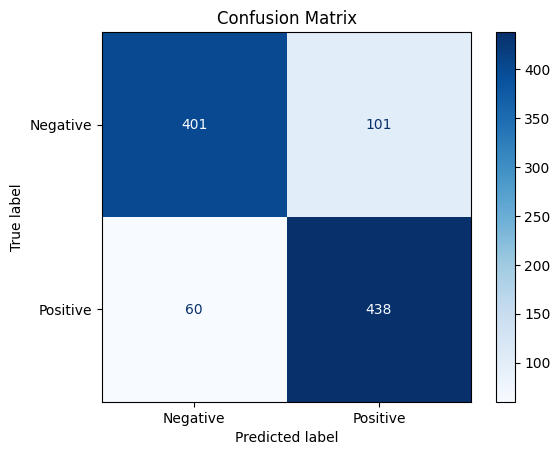

In [35]:
plot_confusion_matrix(y_test, y_pred_lr, LABELS)

## Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)

accuracy_score(y_test, y_pred_rf)

0.808

In [37]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       502
         1.0       0.79      0.83      0.81       498

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



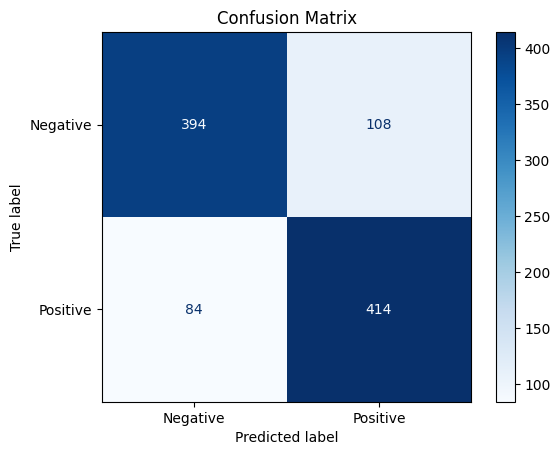

In [38]:
plot_confusion_matrix(y_test, y_pred_rf, LABELS)

## Support Vector Machines

In [39]:
from sklearn.svm import SVC  

clf = SVC(kernel='linear') 
 
# fitting x samples and y classes 
clf.fit(X_train, y_train) 
y_pred_clf = clf.predict(X_test)

accuracy_score(y_test, y_pred_clf)

0.864

In [40]:
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86       502
         1.0       0.85      0.89      0.87       498

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



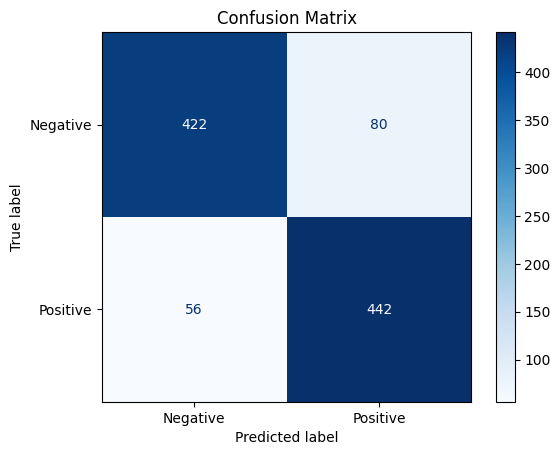

In [41]:
plot_confusion_matrix(y_test, y_pred_clf, LABELS)

# Advanced Model Implementations

### Tokenization and padding

In [42]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['review'])
X = pad_sequences(tokenizer.texts_to_sequences(df['review']), maxlen=300)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### DataLoader for Training and Testing

In [43]:
# Define custom dataset class for PyTorch
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for training and testing
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Hyperparameters

In [44]:
# Hyperparameters
vocab_size = 10000
embed_size = 256
hidden_size = 128
output_size = 1
num_layers = 2
dropout = 0.5
learning_rate = 0.001
num_epochs = 7

## LSTM: Long-Short-Term Memory model in PyTorch

In [45]:
# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        h_lstm, (h_n, c_n) = self.lstm(x)
        out = h_lstm[:, -1, :]  # Get the output of the last LSTM cell
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

# Initialize model, loss function, and optimizer
model = LSTMModel(vocab_size, embed_size, hidden_size, output_size, num_layers, dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train the Model

In [46]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/7], Loss: 0.6418
Epoch [2/7], Loss: 0.4338
Epoch [3/7], Loss: 0.2702
Epoch [4/7], Loss: 0.1680
Epoch [5/7], Loss: 0.1127
Epoch [6/7], Loss: 0.0413
Epoch [7/7], Loss: 0.0363


### Test the Model

In [47]:
# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7810
